# Plan :
* K-Means 
* Clustering Héirarchique 
* L'algorithme DCCA
* Simulation de l'algorithme DCCA
* Discussion

# K-Means :

K-means est un algorithme de clustering qui assigne chaque point à un cluster parmi K. Les clusters vérifient deux propriétés :
1. C1 ∪ C2 ∪ ... ∪ CK = {1,...,n}
2. Ck ∩ Ck = ∅ pour tout k != k'
Le principe de l'algorithme est de definir un nombre K de clusters, affecter les data à des clusters selon une mesure de distance puis recalculer les nouveaux clusters après ajout des data jusqu'à convergence.

L'objectif du K-means est de diminuer la variation inter-cluster se qui peut être formuler de la façon suivante :

$\min_{C_1,...,C_K}\sum_{k=1}^K W(C_k)$ 

Il y a plusieurs variante pour affacter un point x à un cluster:
1. La distance entre x et tous les point dans le cluster est inferieure à la distance entre x et les points hors-cluster
2. Definir un centroide de chaque cluster, affacter x au cluster de centroide le plus proche.
3. x est plus proche d'un ou plusieurs points du cluster que tout autre point hors-cluster.
4. Selon la densité des points.

#### L'algorithme:
Pour l'algorithme on considère l'approche utilisant les centroides. 
Soient un entier K>1, un réel $\varepsilon >0$ et un entier tmax

1. Affecter chaque point à un cluster (1 jusqu'à  K) aléatoirement.

2. Répeter:

    2.1 Calculer le centroide de chaque cluster : ck(x1,...,xn) tel que xi est la moyenne de xi des points dans le cluster.

    2.2 Réaffecter les points au clusters les plus proche 

    2.3 Evaluer le critère d'arret : $ |Val(t-1)-Val(t)| < \varepsilon $ ou nombre d'itération > tmax



# Clustering Héirarchique :

Trouver le bon K pour l'algorithme K-means n'est pas du tout une tache facile. Le clustering Hierarchique est une approche alternative qui ne necessite pas de savoir K.
Le prince de l'algorithme, dans sa version agglomerative (bottom-up), est de considérer initialement autant de clusters que de données et puis grouper les clusters les plus similaires en un nouveau cluster diminuant le nombre de clusters à n-1.

A la fin de l'algorithme un dendogram est construit, qui permet d'obtenir plusierus nombre (K) de clusters.

![alt](hierarchique.png)

# DCCA :

Dans l'article ref1, il propose une version améliorée de K-means: DCCA. L'objectif de DCCA est d'avoir une connectivité entre un point x et le cluster qui est supérieure à la connectivité entre x et tout autre cluster.

$ ∀v \in C_k con(v,C) \geq \max{con(v,C_l) , C_l \in P}$


#### Etape 1 : Trafic Forcast
On définit: Un RRH par le triple (id,lat,ln) et Δt= 24 h
On prédit le trafic par hour pour le jour suivant. L'algorithme MuLSTM prend un Fi et retourne un Fi+1 tel que Fi est une matrice de dimension [Nt,Nr] avec, Nt: nombre de time spans et Nr: nombre des RRHs.
#### Etape 2 : Definition de mesures
1. Distribution de peak hours : Pour un cluster donné, on recupère peak hours des RRHs du cluster, soit T. On calcule par la suite l'entropie de shannon sur les probabilité d'avoir un peak-hour dans le cluster. Une grande valeur de l'entropie implique une grande uncertitude ce qui veut dire une grande dispersion entre les peak hours dans le cluster.
$$H(C)=-\sum_{k=1}^K p_k \log p_k $$

2. L'utilité de la capacité : Le trafic aggréger des RRHs du cluster doit être proche à la capacité de la BBU du cluster sans la dépasser.
$$ U(C)= \left(\frac{meanf(C)}{|B|}\right)^{\ln\frac{meanF(C)}{|B|} }$$

3. Complémentarité : $M(C) = U(C)*H(C)$

4. Matrice de complémentarité: Il faut prendre en considération la distance entre les RRHs pour que les délais de propagation entre BBU et RRH respectent les contraintes de qualité de service, et aussi pour permettre la communication entre RRHs. Donc on définit un $\tau$ tel que les RRHs qui sont séparés par une distance > $\tau$ ne sont pas clusterer ensemble. La matrice de complémentarité a la forme [Nr,Nr] et associe à chaque couple(ri,rj) la valeur $w(ri,rj)= M({ri,rj})*a_ij$ tel que $a_ij = \begin{cases}
1 & \text{si $dist(r_i,r_j) < \tau$,} \\
1 & \text{sinon.}
\end{cases}$ 

5. Connectivité : Elle représente la mesure de distance qui permet d'affecter un RRH à un cluster.
$con(v,C)=\sum_{v'\in C}w_{vv'}$
Il faut prendre de plus la distance de RRH au autre clusters, on definit donc :
$value(v,C)=con(v,C)*\log{\left(\frac{\tau}{max{dist(v,v')}}\right)} $

6. Clusters adjacents : $\mathbb{C}(v)= {C| con(C,v) >0, C \in \mathbb{P}} $

#### Etape 3 : L'algorithme

Dans cette version de K-means, on ne considère pas les centroide des clusters. Un RRH est affecter au cluster qui maximise la connectivité con(v,C)

1. On Affecte chaque RRH à un cluster.
2. On répète :

    2.1. Pour chaque RRH, on calcule les clusters adjacents : AC.
    
    2.3. Parmi les clusters de AC, on recupère celui qui a le value(v,C) max, soit newC.
    
    2.4. Si newC est different de l'ancient cluster de RRH, on reaffecte RRH au nouveau cluster.
    
    2.5. Si aucun RRH n'a changé de cluster ou si on atteint le nombre d'itérations max on s'arrete.
    


# Simulation :


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Mar  5 16:58:33 2020
@author: h_djeddal

L'implementation de méthode de clustering des RRHs proposée dans ref1.

Implementation of RRHs-Clustering method proposed in ref1 
"""

import random
import math
import numpy as np

class RRH:
    def __init__(self,i,lat,lng,t=[]):
        #self.lat=round(random.uniform(lat,lat+0.05),4)
        #self.lng=round(random.uniform(lng,lng+0.05),4)
        self.lat=lat
        self.lng=lng
        self.id=i
        self.trafic=t
        self.peak=[]
    def setTrafic(self,t):
        self.trafic=t
    def setPeak(self,p):
        self.peak=p

def calcul_proba(C):
    proba=[]
    T=[]
    for i in range(len(C)):
        T+=C[i].peak
    longeur=len(T)
    for i in range(len(C[0].trafic)):
        p=T.count(i)/longeur
        if(p>0):
            proba.append(p)
    return proba

def entropie_shannon(p):
    s=0;
    for pi in p:
        s+= math.log(pi)*pi
    return (-s)

def capacity_utility(B,f):
    res=np.mean(f)/B
    l=-math.log1p(res)
    res=math.pow(res,l)
    return res
def aggregationTrafic(C):
    agg=np.zeros(len(C[0].trafic))
    for c in range(0,len(C)):
        agg+=C[c].trafic
    return agg
    
def complementarity(C,B):
    f=aggregationTrafic(C)
    p=calcul_proba(C)
    return (entropie_shannon(p)*capacity_utility(B,f))

def peak_tracking(B,F,r):
    T=[]    
    lesmax= np.amax(F,axis=1)
    minmax=min(lesmax)
    taux=min(int(B/2),minmax)
    #    methode 2: prendre maxligne +- delta=maxmax-minmax
    for i in range(len(F)):
        temp=[]
        for j in range(len(F[i])):
            if(F[i][j]>= taux):
                temp.append(j)
                T.append(j)
        r[i].setPeak(temp)
    return T
    

def distance(r1,r2):
    return math.sqrt((r1.lat-r2.lat)**2+(r1.lng-r2.lng)**2)

def matriceComplementarite(r,B,To):
    A=np.empty([len(r),len(r)])
    for i in range(len(r)):
        for j in range(len(r)):
            if((i!=j) and distance(r[i],r[j])<To):
                A[i][j]=complementarity(np.array([r[i],r[j]]),B)
            else:
                A[i][j]=0
    return A
def connectivity(C,W,rrh):#Calcul par paire
    res=0
    for ri in C:
        res+=W[ri.id][rrh.id]
    return res

"""def connectivity2(C,W,rrh,B):#Calcul par ensemble: ici j'ai pas considéré la matrice W donc la distance n'est 
    Ctest=C.copy()           #pas trop prise en considération sauf aprés la multiplication par 
    Ctest.append(rrh)        #*math.log(taux/maxdist(C,rrh))
    res=complementarity(Ctest,B)
    return res"""
def connectivity2(C,W,rrh,B):#On definit une distance max pour les clusters
    res=0
    Ctest=C.copy()           
    Ctest.append(rrh)
    if(maxdist(C,rrh)<= distMaxC):
        res=complementarity(Ctest,B)
    return res

def adjacent_clusters(P,W,rrh,B):
    AC=[]
    for C in P:
        if(connectivity2(C,W,rrh,B) > 0):
            AC.append(C)
    return AC
def maxdist(C,rrh):
    m=0
    for ri in C:
        d=distance(rrh,ri)
        if(d>m):
            m=d
    return m
def evaluate(C,W,rrh,taux,B):
    c=0
    if(maxdist(C,rrh)!=0):
        c=connectivity2(C,W,rrh,B)#*math.log(taux/maxdist(C,rrh))
    return c

def DCCA(r,F,B,max_iter,taux,W):
    
    P=[]  #list of clusters
    labels=[]   #assigns a label of cluster to each rrh
    #step1: assign every rrh to a cluster
    for rrh in r:
        P.append([rrh])
        labels.append(rrh.id)
    indices=[i for i in range(len(r))]
    #step2 : itere & cluster
    fin=False
    it=0
    while (not fin):
        it+=1
        change=False
        random.shuffle(indices)
        for i in indices:
            rrh=r[i]
            maxvalue=0
            newC=[]
            AC=adjacent_clusters(P,W,rrh,B)
            for C in AC:
                value=evaluate(C,W,rrh,taux,B)
                if(value > maxvalue):
                    maxvalue=value
                    newC=C
            if (newC in P and labels[rrh.id] != P.index(newC)):
                newlabel=P.index(newC)
                oldlabel=labels[rrh.id] 
                labels[rrh.id] = newlabel  #update the label
                newC.append(rrh)   #add rrh to the new cluster
                P[newlabel]=newC   #update P
                P[oldlabel].remove(rrh)   #delete rrh from its old cluster
                change=True
        if(change == False or it== max_iter):
            fin=True
    return P,labels
def iterative_DCCA (r,F,max_iter,taux,iter_part):
    B=np.max(F)
    Popt=[]
    lopt=[]
    compOpt=0
    W=matriceComplementarite(r,B,taux)
    for i in range(iter_part):
        P,l=DCCA(r,F,B,max_iter,taux,W)
        c=complemntarity_partition(P,W,taux,B)
        if(c>compOpt):
            compOpt=c
            Popt=P
            lopt=l
    return Popt,lopt
     
def complemntarity_partition(P,W,To,B):
    s=0
    for C in P:
        for rrh in C:
            if(len(C)>1):
                s+= evaluate(C,W,rrh,To,B)
            else:
                s+=connectivity2(C,W,rrh,B)
    return s
def print_p(P):
    for C in P:
        print("Cluster : ")
        for r in C:
            print(r.id)
        
    
def normalize_trafic(F):
    nblig=len(F)
    nbcol=len(F[0])
    F_norm=np.empty([nblig,nbcol])
    maxf=np.max(F)
    minf=np.min(F)
    for i in range (nblig):
        for j in range(nbcol):
            F_norm[i][j]=((F[i][j]-minf)/(maxf-minf))
    return F_norm

In [2]:
import matplotlib.pyplot as plt
            
distMaxC=0.015
Nr=3 #nombre de RRHs
dt=1  #DeltaT = 1heure
Nt=int(24/dt)  #nombre de timespan  par jour
NBBU=2
CBBU=1
To=0.024
max_iter=20
lat=48.85
lng=2.34


"""
Génération de Fj : Fj a la structure [Nr,Nt] et contient le traffic prédit 
pour les RRHs à differents time spans (forcast hourly traffic for the next day).
methode : MuLSTM
Dans cette simulation, on génère nous même la matrice pour tester. 
""" 
F=np.empty([Nr,Nt])
F=np.array([[3,5,7,12,19,15,10,5,3,2,2,5,6,8,7,7,8,10,18,19,15,10,2,2],
           [3,3,3,2,2,2,2,2,2,8,9,15,18,4,2,3,2,7,15,18,8,2,2,2],
            [3,3,5,12,18,11,5,2,2,5,6,10,18,14,12,8,5,5,5,3,2,2,2,2]])
F_norm=normalize_trafic(F)


# CREATION DES RRHs
r=[]   #liste des RRHs
r.append(RRH(0,48.22,2.55,F_norm[0]))
r.append(RRH(1,48.23,2.53,F_norm[1]))
r.append(RRH(2,48.24,2.52,F_norm[2]))
 
T=peak_tracking(CBBU,F_norm,r)  
W=matriceComplementarite(r,CBBU,To)
#P,l=DCCA.DCCA(r,F_norm,CBBU,max_iter,To)
P,l=iterative_DCCA (r,F_norm,max_iter,To,6)

print(l)
for C in (P):
    alts=[]
    lngs=[]
    if(C != []):
        print(complementarity(C,CBBU))
        for j in (C):
            alts.append(j.lat)
            lngs.append(j.lng)
    plt.scatter(alts,lngs)



[0, 2, 2]
4.344646303259099
4.223525390405922


[2, 1, 1]
1.8423380299147984
1.895172011799765
[0, 2, 2]
1.895172011799765
1.8423380299147984
[0, 1, 1]
1.895172011799765
1.8423380299147984
[2, 1, 1]
1.8423380299147984
1.895172011799765
[0, 1, 1]
1.895172011799765
1.8423380299147984
[0, 2, 2]
1.895172011799765
1.8423380299147984


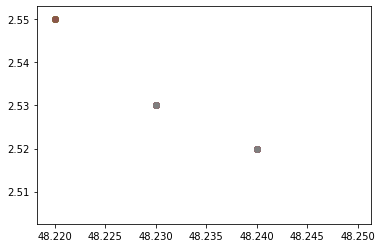

In [3]:
period=6
for i in range(period):
    x=int(24/period)
    Fi=F_norm[:,i*x:(i+1)*x]
    T=peak_tracking(CBBU,Fi,r)  
    P,l=iterative_DCCA (r,Fi,max_iter,To,6)
    print(l)
    for C in (P):
        alts=[]
        lngs=[]
        if(C != []):
            print(complementarity(C,CBBU))
            for j in (C):
                alts.append(j.lat)
                lngs.append(j.lng)
        plt.scatter(alts,lngs)
